In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [34]:
# set hyperparameters
vocab_size = 7000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_size = 20000
num_epochs = 30

# set hyperparameters
# vocab_size = 10000
# embedding_dim = 16
# max_length = 100
# trunc_type = 'post'
# padding_type = 'post'
# oov_tok = '<OOV>'
# training_size = 20000
# num_epochs = 30

In [4]:
# download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-01-16 08:55:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 172.253.117.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-01-16 08:55:59 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [5]:
# open and read dataset
with open('/tmp/sarcasm.json', 'r') as jsonfile:
    datastore = json.load(jsonfile)

In [8]:
datastore[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [6]:
# split the dataset into sentences and labels
sentences = []
labels = []

for i in datastore:
    sentences.append(i['headline'])
    labels.append(i['is_sarcastic'])

In [33]:
print('total texts:', len(sentences))

total texts: 26709


In [7]:
# split training and test sets
train_sentences = sentences[:training_size]
test_sentences = sentences[training_size:]

train_labels = labels[:training_size]
test_labels = labels[training_size:]

In [35]:
# instantiate Tokenizer and fit on the texts
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

In [36]:
# get useful info about the texts
word_index = tokenizer.word_index
word_count = tokenizer.word_counts
index_word = tokenizer.index_word

In [18]:
# most frequent words
[(k, v) for k, v in word_count.items() if v > 2000]

[('for', 2490),
 ('the', 3906),
 ('to', 6202),
 ('in', 3158),
 ('a', 2318),
 ('of', 4267)]

In [37]:
# convert training sentences to encoded tokens then pad them
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [38]:
# convert test sentences to encoded tokens then pad them
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [39]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np

train_padded = np.array(train_padded)
train_labels = np.array(train_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [45]:
# define model
model = tf.keras.Sequential(name='course3_week2_lesson2_model')
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [41]:
model.summary()

Model: "course3_week2_lesson2_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           112000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 112,577
Trainable params: 112,577
Non-trainable params: 0
_________________________________________________________________


In [42]:
# define callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.92:
            print('\ntraining reached accuracy more than 92% in training set. Training terminated')
            self.model.stop_training = True

callback = myCallback()

In [46]:
history = model.fit(x=train_padded, y=train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels)) #callbacks=[callback]

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.6795 - acc: 0.5686 - val_loss: 0.4897 - val_acc: 0.7961
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 0.4131 - acc: 0.8280 - val_loss: 0.3658 - val_acc: 0.8459
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2947 - acc: 0.8795 - val_loss: 0.3480 - val_acc: 0.8517
Epoch 4/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2430 - acc: 0.9058 - val_loss: 0.3502 - val_acc: 0.8498
Epoch 5/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2210 - acc: 0.9128 - val_loss: 0.3634 - val_acc: 0.8430
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2023 - acc: 0.9233 - val_loss: 0.3819 - val_acc: 0.8429
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.1790 - acc: 0.9310 - val_loss: 0.3954 - val_acc: 0.8408
Epoch 8/30
625/625 [==============================] - 2s 4ms/step - loss: 0.

`Epoch 30/30`</br>
`625/625 [==============================] - 3s 4ms/step - loss: 0.0170 - acc: 0.9950 - val_loss: 1.2788 - val_acc: 0.8086`
</br>
</br>
`Epoch 30/30`</br>
`625/625 [==============================] - 2s 4ms/step - loss: 0.0653 - acc: 0.9807 - val_loss: 0.9951 - val_acc: 0.8077`

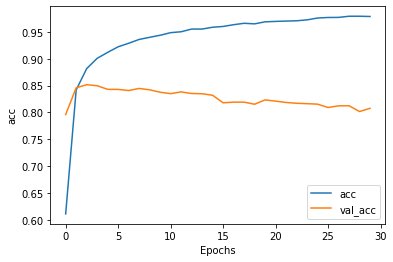

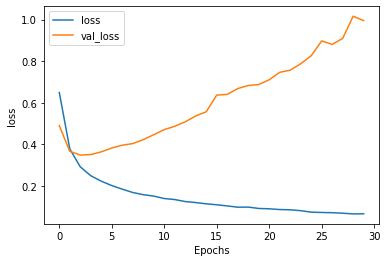

In [47]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [28]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(train_padded[2]))
print(train_sentences[2])
print(labels[2])

mom starting to fear son's web series closest thing she will have to grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [29]:
print(tokenizer.sequences_to_texts([train_padded[2]])[0])
print(train_sentences[2])
print(train_labels[2])

mom starting to fear son's web series closest thing she will have to grandchild <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
mom starting to fear son's web series closest thing she will have to grandchild
1


In [31]:
# get weights from the embedding layer
emb_layer = model.layers[0]
weights = emb_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [48]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.993432e-01]
 [6.375077e-04]]
